<a href="https://colab.research.google.com/github/gsilsbe/Missouri_Reservoirs/blob/main/match_MU_to_DNR_WBID_7630.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
!pip install rtree
import rtree
import json

from shapely import geometry, ops
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.geometry.multipolygon import MultiPolygon
from shapely.ops import cascaded_union
from shapely.ops import unary_union

from shapely import intersection
from shapely import intersects
from shapely import concave_hull
from shapely import difference, within, contains
import os

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.2/535.2 kB 7.4 MB/s eta 0:00:00


Index(['geometry', 'FID', 'TBLE_NAME', 'NHD', 'METADATA', 'STNDRD_ID',
       'WBID_TXT', 'WATER_BODY', 'WB_CLS', 'DS_COUNTY', 'US_COUNTY', 'HUC_8',
       'SIZE_', 'UNIT', 'LEGAL_DS', 'AQL_USE', 'CDF_USE', 'DWS_USE', 'IND_USE',
       'IRR_USE', 'LWW_USE', 'SCR_USE', 'WBCA_USE', 'WBCB_USE', 'HHP_USE',
       'NNC', 'PERM_ID', 'REACHCODE', 'Shape__Area', 'Shape__Length'],
      dtype='object')

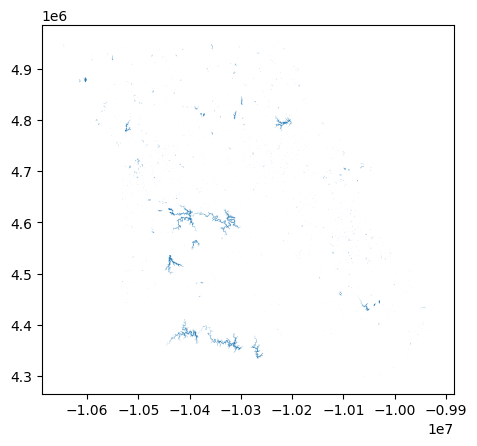

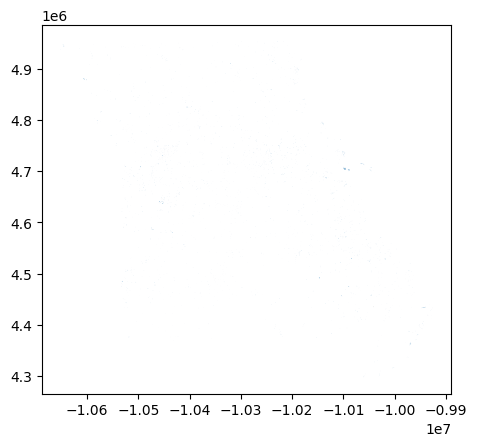

In [4]:
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)

MO_DNR = gpd.read_file("MO_2020_WQS_Lake_Classification_and_Use.geojson", driver='GeoJSON')
MO_DNR = MO_DNR.drop(columns="EVENTDAT").drop(columns="REACHSMDAT").round(0)
MO_DNR_7630 = MO_DNR[MO_DNR["WATER_BODY"] =="100K Extent-Remaining Lakes"]
MO_DNR = MO_DNR.to_crs(crs=3857)
MO_DNR_7630 = MO_DNR_7630.to_crs(crs=3857)
MO_DNR = MO_DNR.dissolve(by="WBID")
# Plot
MO_DNR.plot()
MO_DNR_7630.plot()

# Column names
MO_DNR.keys()

## Read in MU data, convert lat lon columns to geometry

Index(['waterBodyID', 'WBID', 'MULakeNumber', 'waterBody', 'WATER_BODY_DNR',
       'waterBodyLatitude', 'waterBodyLongitude', 'ecoregionID', 'damHeightM',
       'volumeM3', 'surfAreaHA', 'watershedAreaHA', 'geometry'],
      dtype='object')

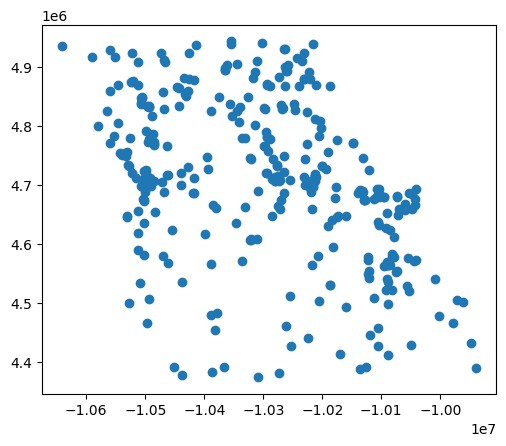

In [6]:
MU = pd.read_csv('MU_v_DNR.csv')
MU = MU[MU['stateID']==29]
MU = MU.drop(columns="Distance").drop(columns="waterBodyDesc").drop(columns="countyID").drop(columns="countryID").drop(columns="stateID").drop(columns="waterBodyTypeID").drop(columns="MDNRNameID").drop(columns="primarySLAP19").drop(columns="notes").drop(columns="geometry")
MU_gdf = gpd.GeoDataFrame(MU, geometry=gpd.points_from_xy(MU.waterBodyLongitude, MU.waterBodyLatitude) ).set_crs(4326)
MU_gdf = MU_gdf.to_crs(crs=3857)
MU_gdf["WBID"] = MU_gdf["WBID"].fillna(0).astype(int) # convert just column WBID to integer
MU_gdf.plot()
MU_gdf.keys()

In [7]:
# Creating an index based on rows of MO_DNR
index = rtree.index.Index()
for idx, row in MO_DNR.iterrows():
  index.insert(idx, row.geometry.bounds)

Find nearest WaterBody

In [39]:
for i in range(0,len(MU_gdf)):
  if MU_gdf.iloc[i]["WBID"] ==7630: # Gets geometry of closest WBID 760
    distances = np.zeros(len(MO_DNR))
    for j in range(0, len(MO_DNR)):
        distances[j] = MU_gdf.iloc[i].geometry.distance(MO_DNR_7630.iloc[j].geometry.centroid)
    idx = np.argmin(distances)
    MU_gdf.iloc[i, MU_gdf.columns.get_loc('geometry')] =  MO_DNR_7630.iloc[idx].geometry
  elif MU_gdf.iloc[i]['WBID']!=0: # Gets geometry based on WBID
    #idx = MU_gdf.loc[i]['WBID']
    idx = list(index.intersection(MU_gdf.iloc[i].geometry.bounds))[0]
    #print(idx)
    MU_gdf.iloc[i, MU_gdf.columns.get_loc('geometry')] = MO_DNR.loc[idx].geometry
  else: # Looks for MU#.geojson
    if os.path.exists(str(MU_gdf.iloc[i]["MULakeNumber"]) + '.geojson'):
      print('great ' + str(MU_gdf.iloc[i]["MULakeNumber"]) + '.geojson')
      gee_gdf = gpd.read_file(str(MU_gdf.iloc[i]["MULakeNumber"]) + '.geojson', driver='GeoJSON')
      if len(gee_gdf) > 1:
        MU_gdf.iloc[i, MU_gdf.columns.get_loc('geometry')]= gee_gdf.iloc[foo.area.idxmax()].geometry
      else:
        MU_gdf.iloc[i, MU_gdf.columns.get_loc('geometry')] = gee_gdf.geometry


great 76.geojson
great 160.geojson


<ipython-input-39-cac80ea72b2f>:18: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  MU_gdf.iloc[i, MU_gdf.columns.get_loc('geometry')]= gee_gdf.iloc[foo.area.idxmax()].geometry
<ipython-input-39-cac80ea72b2f>:18: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  MU_gdf.iloc[i, MU_gdf.columns.get_loc('geometry')]= gee_gdf.iloc[foo.area.idxmax()].geometry


great 215.geojson
great 236.geojson
great 243.geojson
great 245.geojson
great 246.geojson
great 247.geojson
great 249.geojson
great 252.geojson
great 282.geojson


<ipython-input-39-cac80ea72b2f>:18: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  MU_gdf.iloc[i, MU_gdf.columns.get_loc('geometry')]= gee_gdf.iloc[foo.area.idxmax()].geometry
<ipython-input-39-cac80ea72b2f>:18: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  MU_gdf.iloc[i, MU_gdf.columns.get_loc('geometry')]= gee_gdf.iloc[foo.area.idxmax()].geometry
<ipython-input-39-cac80ea72b2f>:18: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  MU_gdf.iloc[i, MU_gdf.columns.get_loc('geometry')]= gee_gdf.iloc[foo.area.idxmax()].geometry
<ipython-input-39-cac80ea72b2f>:18: UserWarning: Geometry is in 

great 292.geojson
great 294.geojson
great 301.geojson


<ipython-input-39-cac80ea72b2f>:18: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  MU_gdf.iloc[i, MU_gdf.columns.get_loc('geometry')]= gee_gdf.iloc[foo.area.idxmax()].geometry
<ipython-input-39-cac80ea72b2f>:18: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  MU_gdf.iloc[i, MU_gdf.columns.get_loc('geometry')]= gee_gdf.iloc[foo.area.idxmax()].geometry
<ipython-input-39-cac80ea72b2f>:18: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  MU_gdf.iloc[i, MU_gdf.columns.get_loc('geometry')]= gee_gdf.iloc[foo.area.idxmax()].geometry
<ipython-input-39-cac80ea72b2f>:18: UserWarning: Geometry is in 

great 302.geojson
great 311.geojson
great 312.geojson
great 322.geojson
great 403.geojson
great 404.geojson
great 409.geojson
great 412.geojson


<ipython-input-39-cac80ea72b2f>:18: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  MU_gdf.iloc[i, MU_gdf.columns.get_loc('geometry')]= gee_gdf.iloc[foo.area.idxmax()].geometry
<ipython-input-39-cac80ea72b2f>:18: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  MU_gdf.iloc[i, MU_gdf.columns.get_loc('geometry')]= gee_gdf.iloc[foo.area.idxmax()].geometry


great 440.geojson
great 441.geojson
great 445.geojson
great 448.geojson
great 450.geojson
great 452.geojson


<ipython-input-39-cac80ea72b2f>:18: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  MU_gdf.iloc[i, MU_gdf.columns.get_loc('geometry')]= gee_gdf.iloc[foo.area.idxmax()].geometry
<ipython-input-39-cac80ea72b2f>:18: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  MU_gdf.iloc[i, MU_gdf.columns.get_loc('geometry')]= gee_gdf.iloc[foo.area.idxmax()].geometry


great 457.geojson


<ipython-input-39-cac80ea72b2f>:18: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  MU_gdf.iloc[i, MU_gdf.columns.get_loc('geometry')]= gee_gdf.iloc[foo.area.idxmax()].geometry


great 462.geojson
great 464.geojson
great 465.geojson


<ipython-input-39-cac80ea72b2f>:18: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  MU_gdf.iloc[i, MU_gdf.columns.get_loc('geometry')]= gee_gdf.iloc[foo.area.idxmax()].geometry
<ipython-input-39-cac80ea72b2f>:18: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  MU_gdf.iloc[i, MU_gdf.columns.get_loc('geometry')]= gee_gdf.iloc[foo.area.idxmax()].geometry


Insert GEE Shapefiles testing

In [41]:
# Saving a geojson file

# First converts the GeoDataFrame to a JSON string
json_string = MU_gdf.to_json(na="drop")

# Then, it opens a file called data.json for writing and uses the json.dump() function to write the JSON string to the file
with open("MU.json", "w") as f:
    json.dump(json_string, f)

In [43]:
# Saving as csv
pd.DataFrame(MU_gdf).to_csv("MU geometry.csv")

In [ ]:
# iloc method uses an integer indexing
# loc method supports both integer and label-based indexing

MO_WATERBODY = MO_DNR.loc[idx]['WATER_BODY']
MO_WBID = MO_DNR.loc[idx]['WBID']
MO_WATERBODY.index = MU_gdf.index
MO_WBID.index = MU_gdf.index
distance = pd.Series(distance, index =  MU_gdf.index)

final_MU = pd.concat([MU_gdf, MO_WATERBODY, MO_WBID, distance], axis=1)
#final_MU.to_csv("MU_v_DNR.csv")
final_MU

In [ ]:
final_MU

In [ ]:
idx1 = np.argmin(distance_to_shore, axis=1)
idx2 = np.argmax(within_boolean, axis=1)
idx = idx2
np.copyto(idx, idx1, where=idx== 0)
print(idx)

[176 248   3   2  48  53  55 254 242 240 185 184 306 257 303 469 477 478
 300 264 266 265 326 272 517 517 310 339 334 325 321 322 318 324 324 323
 330 298 293 199 488 181 182 157 172 165 170 167 149 153 152  12  10  18
  25  14 414  41  33  50 492 186  92 102 101  90  96 213 217  71  76  85
  86  66  63 449 123 122 121 117 114 108 131 130 435 137 135 206 207 233
 237 234 354 235 236 311 313 313 314 316 315 319 238 244 281 280 320 286
 287 470 191  23  28 100 179 212 148 211 189  19  35   8  40  39  22  38
 151  17 150 103 127 160 159 119  13 105 404  32 332 356 204 188 481  70
 192 358 383 383 231 396 111 145 389 372 377 401 381 376 519  75 366 400
   7 385 197 384 329 363 347 228  57 387 146 489  81 110 208  56  82 163
  60 273  49 434 109 120 382 118 500  32 250 523 158 505 505  24  20  27
 502 196 196 532 104 112 113  37 503 142 187 115 176 143  30  21 538 490
 439 451 169 387 387 387 440 173 508 144 490 446 249   9 450 249 202 496
 224 239 227 229 422 205 327 331  31 437  46  93 11

In [ ]:
DNR_WATER_BODY = MO_DNR.iloc[idx]['WATER_BODY']
DNR_WATER_BODY.index = geo_df.index
DNR_FID = MO_DNR.iloc[idx]['FID']
DNR_FID.index = geo_df.index
DNR_STNDRD_ID = MO_DNR.iloc[idx]['STNDRD_ID']
DNR_STNDRD_ID.index = geo_df.index
DNR_Area = MO_DNR.iloc[idx]['Shape__Area']
DNR_Area.index = geo_df.index
DNR_Length = MO_DNR.iloc[idx]['Shape__Length']
DNR_Length.index = geo_df.index
DNR_HUC_8 = MO_DNR.iloc[idx]['HUC_8']
DNR_HUC_8.index = geo_df.index

final_MU_DNR = pd.concat([geo_df, DNR_WATER_BODY, DNR_FID, DNR_STNDRD_ID, DNR_Area,DNR_Length,DNR_HUC_8], axis=1)
final_MU_DNR.to_csv("MU DNR.csv")